In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from qiskit_metal.analyses.quantization.lumped_capacitive import load_q3d_capacitance_matrix
from qiskit_metal.analyses.quantization.lom_core_analysis import CompositeSystem, Cell, Subsystem 

from scipy.constants import speed_of_light as c_light

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example: two transmons coupled by a direct coupler 
this part is identical to tutorial 4.05; please reference it for more detailed comments

### load transmon cell Q3d simulation results

In [28]:
path1 = './Q1_TwoTransmon_CapMatrix.txt'
ta_mat, _, _, _ = load_q3d_capacitance_matrix(path1)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Q1_TwoTransmon_CapMatrix.txt


,coupler_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
coupler_connector_pad_Q1,59.20,-37.28,-2.01,-19.11,-0.23
ground_main_plane,-37.28,246.33,-39.79,-39.86,-37.30
pad_bot_Q1,-2.01,-39.79,93.05,-30.61,-19.22
pad_top_Q1,-19.11,-39.86,-30.61,92.99,-2.01
readout_connector_pad_Q1,-0.23,-37.30,-19.22,-2.01,59.33


In [29]:
path2 = './Q2_TwoTransmon_CapMatrix.txt'
tb_mat, _, _, _ = load_q3d_capacitance_matrix(path2)

Imported capacitance matrix with UNITS: [fF] now converted to USER UNITS:[fF]                 from file:
	./Q2_TwoTransmon_CapMatrix.txt


,coupler_connector_pad_Q2,ground_main_plane,pad_bot_Q2,pad_top_Q2,readout_connector_pad_Q2
coupler_connector_pad_Q2,64.52,-38.63,-2.18,-22.93,-0.22
ground_main_plane,-38.63,267.40,-49.28,-49.30,-38.67
pad_bot_Q2,-2.18,-49.28,121.38,-45.24,-23.06
pad_top_Q2,-22.93,-49.30,-45.24,121.24,-2.18
readout_connector_pad_Q2,-0.22,-38.67,-23.06,-2.18,64.70


### Create LOM cells from capacitance matrices

In [5]:
# cell 1: transmon Alice cell

opt1 = dict(
    node_rename = {'coupler_connector_pad_Q1': 'coupling', 'readout_connector_pad_Q1': 'readout_alice'}, 
    cap_mat = ta_mat,
    ind_dict = {('pad_top_Q1', 'pad_bot_Q1'):10},  # junction inductance in nH
    jj_dict = {('pad_top_Q1', 'pad_bot_Q1'):'j1'},
    cj_dict = {('pad_top_Q1', 'pad_bot_Q1'):2}, # junction capacitance in fF

)
cell_1 = Cell(opt1)


# cell 2: transmon Bob cell
opt2 = dict(
    node_rename = {'coupler_connector_pad_Q2': 'coupling', 'readout_connector_pad_Q2': 'readout_bob'},
    cap_mat = tb_mat,
    ind_dict = {('pad_top_Q2', 'pad_bot_Q2'): 12}, # junction inductance in nH
    jj_dict = {('pad_top_Q2', 'pad_bot_Q2'):'j2'},
    cj_dict = {('pad_top_Q2', 'pad_bot_Q2'):2}, # junction capacitance in fF

)
cell_2 = Cell(opt2)

### Make subsystems

In [6]:
# subsystem 1: transmon Alice
transmon_alice = Subsystem(name='transmon_alice', sys_type='TRANSMON', nodes=['j1'])


# subsystem 2: transmon Bob
transmon_bob = Subsystem(name='transmon_bob', sys_type='TRANSMON', nodes=['j2'])


# subsystem 3: Alice readout resonator
q_opts = dict(
    f_res = 8, # resonator dressed frequency in GHz
    Z0 = 50, # characteristic impedance in Ohm
    vp = 0.404314 * c_light # phase velocity 
)
res_alice = Subsystem(name='readout_alice', sys_type='TL_RESONATOR', nodes=['readout_alice'], q_opts=q_opts)


# subsystem 4: Bob readout resonator
q_opts = dict(
    f_res = 7.6, # resonator dressed frequency in GHz
    Z0 = 50, # characteristic impedance in Ohm
    vp = 0.404314 * c_light # phase velocity 
)
res_bob = Subsystem(name='readout_bob', sys_type='TL_RESONATOR', nodes=['readout_bob'], q_opts=q_opts)

### Creat the composite system from the cells and the subsystems

In [7]:
composite_sys = CompositeSystem(
    subsystems=[transmon_alice, transmon_bob, res_alice, res_bob], 
    cells=[cell_1, cell_2], 
    grd_node='ground_main_plane',
    nodes_force_keep=['readout_alice', 'readout_bob']
)

In [8]:
cg = composite_sys.circuitGraph()
print(cg)

node_jj_basis:
-------------

['j1', 'pad_bot_Q1', 'j2', 'pad_bot_Q2', 'readout_alice', 'readout_bob', 'coupling']

nodes_keep:
-------------

['j1', 'j2', 'readout_alice', 'readout_bob']


L_inv_k (reduced inverse inductance matrix):
-------------

                j1        j2  readout_alice  readout_bob
j1             0.1  0.000000            0.0          0.0
j2             0.0  0.083333            0.0          0.0
readout_alice  0.0  0.000000            0.0          0.0
readout_bob    0.0  0.000000            0.0          0.0

C_k (reduced capacitance matrix):
-------------

                      j1         j2  readout_alice  readout_bob
j1             63.185549  -0.766012       8.318893    -0.323188
j2             -0.766012  84.343548      -0.342145    10.039921
readout_alice   8.318893  -0.342145      55.591197    -0.144354
readout_bob    -0.323188  10.039921      -0.144354    60.347427




### Generate the hilberspace from the composite system, leveraging the scqubits package

In [9]:
hilbertspace = composite_sys.create_hilbertspace()
hilbertspace = composite_sys.add_interaction()
hilbertspace.hamiltonian()

Quantum object: dims = [[10, 10, 3, 3], [10, 10, 3, 3]], shape = (900, 900), type = oper, isherm = True
Qobj data =
[[-24384.00898603+0.00000000e+00j      0.        +1.08232559e-01j
       0.        +0.00000000e+00j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 [     0.        -1.08232559e-01j -16784.00898603+0.00000000e+00j
       0.        +1.53063953e-01j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 [     0.        +0.00000000e+00j      0.        -1.53063953e-01j
   -9184.00898603+0.00000000e+00j ...      0.        +0.00000000e+00j
       0.        +0.00000000e+00j      0.        +0.00000000e+00j]
 ...
 [     0.        +0.00000000e+00j      0.        +0.00000000e+00j
       0.        +0.00000000e+00j ...  73269.11342615+0.00000000e+00j
       0.        +4.99608155e+02j      0.        +0.00000000e+00j]
 [     0.        +0.00000000e+00j      0.        +0.00000000e+00j
 

### Print the results

In [10]:
hamiltonian_results = composite_sys.hamiltonian_results(hilbertspace, evals_count=30)

Finished eigensystem.     

system frequencies in GHz:
--------------------------
{'transmon_alice': 6.053360688806868, 'transmon_bob': 4.7989883222888094, 'readout_alice': 8.009054820710865, 'readout_bob': 7.604412010766995}

Chi matrices in MHz
--------------------------
                transmon_alice  transmon_bob  readout_alice  readout_bob
transmon_alice     -353.239816     -0.542895      -4.132854    -0.003120
transmon_bob         -0.542895   -263.940098      -0.001154    -1.460416
readout_alice        -4.132854     -0.001154       4.283111    -0.000017
readout_bob          -0.003120     -1.460416      -0.000017     3.829744


In [11]:
hamiltonian_results['chi_in_MHz'].to_dataframe()

,transmon_alice,transmon_bob,readout_alice,readout_bob
transmon_alice,-353.239816,-0.542895,-4.132854,-0.003120
transmon_bob,-0.542895,-263.940098,-0.001154,-1.460416
readout_alice,-4.132854,-0.001154,4.283111,-0.000017
readout_bob,-0.003120,-1.460416,-0.000017,3.829744


In [12]:
composite_sys.compute_gs()

                transmon_alice  transmon_bob  readout_alice  readout_bob
transmon_alice        0.000000     20.115410    -129.897537     3.275638
transmon_bob         20.115410      0.000000       2.678608  -111.508230
readout_alice      -129.897537      2.678608       0.000000     0.436190
readout_bob           3.275638   -111.508230       0.436190     0.000000

In [14]:
transmon_alice.h_params

{'EJ': 16346.15128067812,
 'EC': 312.756868730393,
 'Q_zpf': 3.204353268e-19,
 'default_charge_op': Operator(op=array([[-22,   0,   0, ...,   0,   0,   0],
        [  0, -21,   0, ...,   0,   0,   0],
        [  0,   0, -20, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  20,   0,   0],
        [  0,   0,   0, ...,   0,  21,   0],
        [  0,   0,   0, ...,   0,   0,  22]]), add_hc=False)}

In [15]:
transmon_bob.h_params

{'EJ': 13621.792733898432,
 'EC': 234.32409269967633,
 'Q_zpf': 3.204353268e-19,
 'default_charge_op': Operator(op=array([[-22,   0,   0, ...,   0,   0,   0],
        [  0, -21,   0, ...,   0,   0,   0],
        [  0,   0, -20, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  20,   0,   0],
        [  0,   0,   0, ...,   0,  21,   0],
        [  0,   0,   0, ...,   0,   0,  22]]), add_hc=False)}

### ***********

## Time evolution simulation with Sequencing https://sequencing.readthedocs.io/en/latest/index.html

In [16]:
%config InlineBackend.figure_formats = ['svg']

import qutip
from tqdm import tqdm

from sequencing import get_sequence, sync
from sequencing.calibration import tune_rabi

from qiskit_metal.analyses.quantization.lom_time_evolution_sim import lom_composite_sys_to_seq_sys

### A simple example: selective qubit pulse in the strong dispersive regime

<img src="number_splitting.png" width=600 height=600 />

\* *Dave Schuster's thesis* https://rsl.yale.edu/sites/default/files/files/RSL_Theses/SchusterThesis.pdf

#### LOM composite system to Sequencing system

<img src="sequencing_h.png" width=600 height=600 />

\* Sequencing documentation, https://sequencing.readthedocs.io/en/latest/notebooks/introduction.html

In this part of the demo, we essentially **reproduce the exact same example as demonstrated in the Sequencing tutorial**, "Controlling a Transmon coupled to Cavity", https://sequencing.readthedocs.io/en/latest/notebooks/06-transmon-cavity-control.html, by generating a Sequencing system converted from a LOM composite system. Hence please follow the Sequencing tutorial for more detailed explanations on the pulse construction, calibration and ultimately simulation.

##### Convert Metal LOM system to Sequencing system
A Qiskit Metal LOM subsystem corresponds to a 'mode' in Sequencing system. The diagonal elements in `hamiltonian_results['chi_in_MHz']` (anharmonicity) are the self-Kerr's and the off-diagonal elements the cross-Kerr's in Sequencing's Hamiltonian screenshot above.

For more details on modes in Sequencing system, please check out the Sequencing package's documentation. The `levels` parameter specifies the number of energy levels to keep for each mode in the Sequencing system. If not specified, i.e., None, they default to LOM subsystem's respective dimensions as represented by the LOM composite system's hilberspace (`hilbertspace.subsystem_dims`)

In [33]:
system = lom_composite_sys_to_seq_sys(composite_sys, hilbertspace, levels=[3, 3, 10, 10])

Finished eigensystem.     


In [34]:
alice = system.modes[1]
readout_alice = system.modes[-1]
print(alice)
print(readout_alice)

Transmon(name='transmon_alice', cls='sequencing.modes.Transmon', levels=3, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=-0.3532398157382704, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, length=100, sigma=0, shape='tanh'), 'gaussian_pulse': GaussianPulse(name='gaussian_pulse', cls='sequencing.pulses.GaussianPulse', amp=1.0, detune=0.0, phase=0.0, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, sigma=10, chop=4, drag=0.0)}, default_pulse='gaussian_pulse')
Cavity(name='readout_alice', cls='sequencing.modes.Cavity', levels=10, t1=inf, t2=inf, thermal_population=0.0, df=0.0, kerr=0.004283110746677267, pulses={'smoothed_constant_pulse': SmoothedConstantPulse(name='smoothed_constant_pulse', cls='sequencing.pulses.SmoothedConstantPulse', amp=1.0, detune=0.0, phase=0.0, noise_sigma=0.0, noise_alpha=0.0, scale

### Are there zero photon in the cavity?

#### Tune the amplitude of a pulse on Alice using an amplitude-Rabi sequence

100%|██████████| 51/51 [00:01<00:00, 35.27it/s]


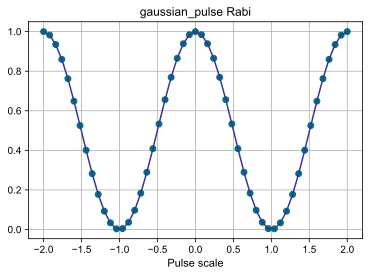

In [35]:
selective_sigma = 100 # ns

# tune selective qubit pulse using Rabi
with system.use_modes([alice]):
    with alice.temporarily_set(gaussian_pulse__sigma=selective_sigma):
        _, _, selective_qubit_amp = tune_rabi(
            system, system.fock(transmon_alice=0, transmon_bob=0, readout_alice=0, readout_bob=0), mode_name=alice.name, update=False, plot=True, verify=False
        )

In [36]:
def selective_rotation(qubit, angle, phase=0, detune=0, sigma=selective_sigma):
    with qubit.gaussian_pulse.temporarily_set(sigma=sigma, amp=selective_qubit_amp):
         qubit.rotate(np.pi, phase, detune=detune)

#### Populate alice readout cavity with 0, 1, 2, 3 photons respectively

In [37]:
init_states = [
    (f'$|g{n}\\rangle$', system.fock(transmon_alice=0, readout_alice=n)) for n in range(4)
]

In [38]:
# Apply a selective pi pulse that is resonant
# with the qubit when the cavity is in |0>.
results = {}

seq = get_sequence(system)
selective_rotation(alice, np.pi)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    results[label] = result

Initial states: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


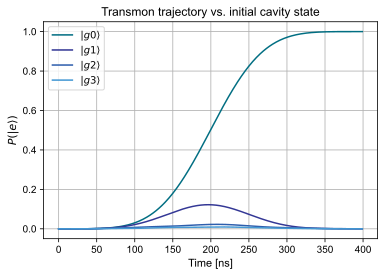

In [39]:
fig, ax = plt.subplots(1, 1)
for label, result in results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(alice.index) for state in result.states]
    e_pops = qutip.expect(alice.fock_dm(1, full_space=False), qubit_states)
    ax.plot(result.times, e_pops, label=label)
    ax.grid(True)
    ax.legend(loc=0)
ax.set_xlabel('Time [ns]')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title('Transmon trajectory vs. initial cavity state')

#### Use the qubit to measure the cavity: how many photons are there?

In [40]:
def rotate_qubit_on_n(system, n, angle, qubit_name='transmon_alice', cavity_name='readout_alice'):
    """Rotate the qubit state iff the cavity is in state |n> by detuning
    the selective qubit pulse by n * chi.
    """
    qubit = system.get_mode(qubit_name)
    cavity = system.get_mode(cavity_name)
    chi = system.cross_kerrs[frozenset([qubit.name, cavity.name])]
    selective_rotation(qubit, angle, detune=n*chi)

##### Displace the cavity and then apply selective pulse on alice

In [41]:
max_n = 4

init_state = system.ground_state()
# qubit in |e> after selective pi pulse means cavity in |n>
e_op = alice.fock_dm(1, full_space=False)
disp_amps = np.linspace(0.01, 3, 21)
e_pops = []

for n in range(max_n):
    e_pops.append([])
    for amp in tqdm(disp_amps, desc=f'Disp. amp. (measure n={n})'):
        seq = get_sequence(system)

        readout_alice.displace(amp)
        sync()
        rotate_qubit_on_n(system, n, np.pi)
        result = seq.run(init_state)
        # trace over the cavity
        transmon_state = result.states[-1].ptrace(alice.index)
        e_pops[-1].append(qutip.expect(e_op, transmon_state))

Disp. amp. (measure n=3): 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


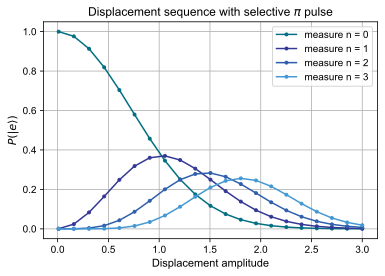

In [42]:
fig, ax = plt.subplots()
for n, es in enumerate(e_pops):
    ax.plot(disp_amps, es, '.-', label=f'measure n = {n}')
ax.legend(loc=0)
ax.grid(True)
ax.set_xlabel('Displacement amplitude')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title(r'Displacement sequence with selective $\pi$ pulse')